In [1]:
import time
import warnings
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from joblib import Parallel, delayed, cpu_count
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
    
param_grid_nn = {
        'hidden_layer_sizes': [(50,), (100,), (50, 30), (25, 25), (50, 50), (100, 100, 100), (50, 25)],
        'activation': ['relu', 'tanh', 'logistic'],
        'alpha': [0.0001, 0.001],
        'max_iter': [800, 1000, 1200] 
    }

In [ ]:
def treinar_avaliar(params, X_train, y_train, X_test, y_test):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        
        model = MLPClassifier(**params, random_state=42)
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        return (score, params)

def grid_search_paralelo(param_grid, n_cpus, X_train, y_train, X_test, y_test):
    start_time = time.time()
    param_combinations = list(ParameterGrid(param_grid))
    total_combinations = len(param_combinations)
    print(f"Iniciando busca PARALELA com {total_combinations} combinações e {n_cpus} núcleos")

    results = Parallel(n_jobs=n_cpus, backend="loky")(
        delayed(treinar_avaliar)(params, X_train, y_train, X_test, y_test) for params in param_combinations
    )

    execution_time = time.time() - start_time
    print(f"Busca paralela concluída em {execution_time:.2f} segundos.\n")

    # Encontra o melhor resultado na lista de tuplas retornada
    best_score, best_params = max(results, key=lambda item: item[0])
    return best_params, best_score, execution_time

In [ ]:
lista_media_execucao = []
lista_sd_execucao = []
n_cpus = []

for ncpus in range(1, cpu_count() + 1):
    lista_tempo_atual = []
    n_cpus.append(ncpus)
    for i in range(100):
        _, _, tempo = grid_search_paralelo(param_grid=param_grid_nn, n_cpus=ncpus, X_train=X_train_scaled,
                                 y_train=y_train, X_test=X_test_scaled, y_test=y_test)
        lista_tempo_atual.append(tempo)
    lista_tempo_atual = np.array(lista_tempo_atual)
    lista_media_execucao.append(np.mean(lista_tempo_atual))
    lista_sd_execucao.append(np.std(lista_tempo_atual))

Iniciando busca PARALELA com 126 combinações e 1 núcleos
Busca paralela concluída em 135.40 segundos.

Iniciando busca PARALELA com 126 combinações e 1 núcleos
Busca paralela concluída em 125.35 segundos.

Iniciando busca PARALELA com 126 combinações e 1 núcleos
Busca paralela concluída em 126.51 segundos.

Iniciando busca PARALELA com 126 combinações e 1 núcleos
Busca paralela concluída em 123.19 segundos.

Iniciando busca PARALELA com 126 combinações e 1 núcleos
Busca paralela concluída em 133.98 segundos.

Iniciando busca PARALELA com 126 combinações e 1 núcleos
Busca paralela concluída em 136.36 segundos.

Iniciando busca PARALELA com 126 combinações e 1 núcleos
Busca paralela concluída em 132.10 segundos.

Iniciando busca PARALELA com 126 combinações e 1 núcleos
Busca paralela concluída em 130.32 segundos.

Iniciando busca PARALELA com 126 combinações e 1 núcleos
Busca paralela concluída em 132.06 segundos.

Iniciando busca PARALELA com 126 combinações e 1 núcleos
Busca paralela c

In [3]:
#df_dados = pd.DataFrame({'n_cpus': n_cpus, 'tempo_medio': lista_media_execucao, 'tempo_std': lista_sd_execucao})
df_dados = pd.read_csv("dados.csv")
df_dados

,Unnamed: 0,n_cpus,tempo_medio,tempo_std
0,0,1,132.345624,3.645823
1,1,2,77.777599,3.383736
2,2,3,47.608163,1.505489
3,3,4,41.018003,1.911648
4,4,5,34.178706,1.537791
5,5,6,26.506721,2.017844
6,6,7,24.917164,1.914259
7,7,8,24.319371,2.211862
8,8,9,14.776372,0.972276
9,9,10,14.897795,0.903705


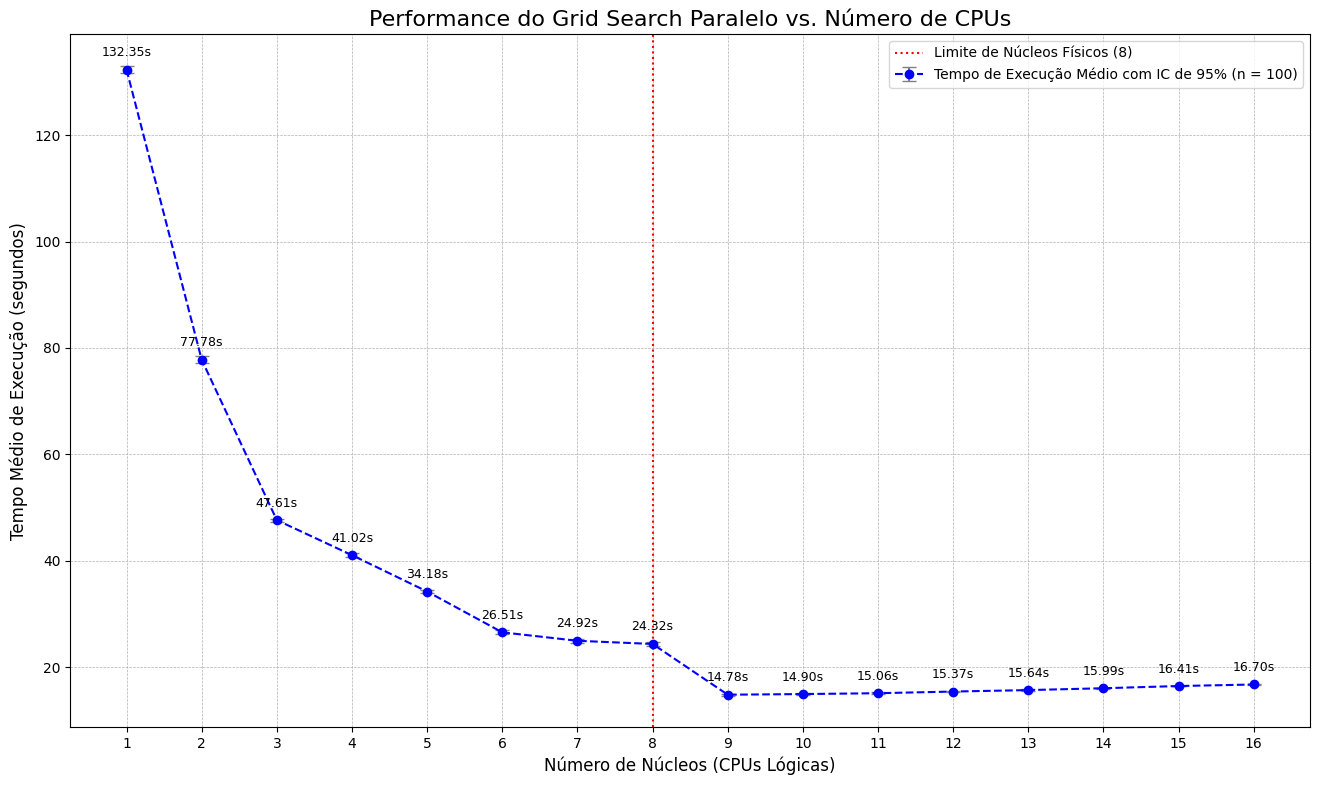

In [ ]:
n = 100
erro_padrao = df_dados['tempo_std'] / np.sqrt(n)
y_error = 1.96 * erro_padrao

plt.figure(figsize=(16, 9))
plt.errorbar(
    x=df_dados['n_cpus'],
    y=df_dados['tempo_medio'],
    yerr=y_error,
    fmt='o',
    linestyle='--',
    color='b',
    ecolor='gray',
    capsize=5,
    label='Tempo de Execução Médio com IC de 95% (n = 100)'
)

for i in range(len(df_dados)):
    x_pos = df_dados['n_cpus'][i]
    y_pos = df_dados['tempo_medio'][i]
    
    label = f"{y_pos:.2f}s"

    plt.text(
        x=x_pos, 
        y=y_pos + 2,
        s=label,
        ha='center',
        va='bottom',
        fontsize=9,
        color='black',
        fontdict={'fontsize': 14}
    )

plt.axvline(x=8, color='r', linestyle=':', label='Limite de Núcleos Físicos (8)')

plt.title('Performance do Grid Search Paralelo vs. Número de CPUs', fontsize=16)
plt.xlabel('Número de Núcleos (CPUs Lógicas)', fontsize=12)
plt.ylabel('Tempo Médio de Execução (segundos)', fontsize=12)
plt.xticks(df_dados['n_cpus'])
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.savefig('benchmark_com_valores.png', dpi=300, bbox_inches='tight')

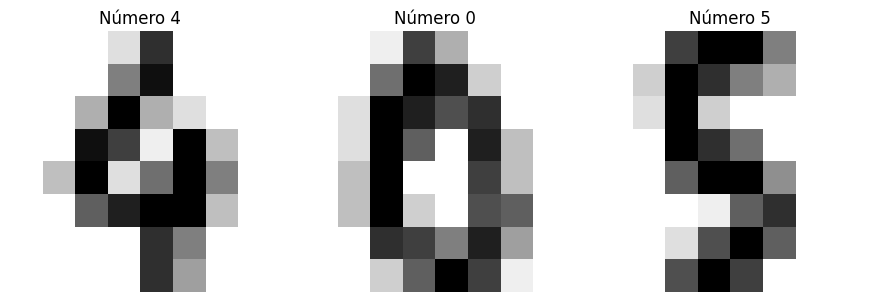

In [27]:
digits = load_digits()
indices = [100, 101, 102]

plt.figure(figsize=(9, 3))

for i, idx in enumerate(indices):
    plt.subplot(1, 3, i + 1)
    plt.imshow(digits.images[idx], cmap=plt.cm.gray_r, interpolation="nearest")
    plt.title(f"Número {digits.target[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()